# Preparation

## Import packages

In [1]:
import os, sys
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import math
import copy
import time

In [2]:
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import merge, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.layers.merge import concatenate
from keras.layers.core import Dropout, Lambda
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Read input

In [3]:
# Band 1: blue; Band 2: green; Band 3: red; Band 4: nir
I = np.load(os.path.join('../data/Training.npy'))
I.shape

(4, 3344, 244, 244)

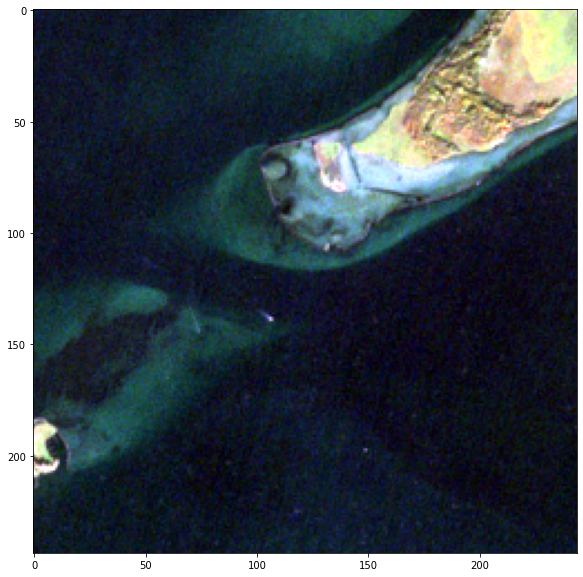

In [4]:
idx = 51
tmp = np.zeros((I.shape[2], I.shape[3], 3), dtype=np.uint8)
for q in range(3):
    a = copy.copy(I[q,idx,:,:])
    D = a>0
    prc = np.percentile(a[D],[1,99])
    tmp[:,:,2-q] = np.digitize(a,np.linspace(prc[0],prc[1],255))*D
plt.imshow(tmp)
plt.savefig('t.png')
f = plt.gcf()
f.set_size_inches(10, 10)
plt.show()

In [5]:
T = np.load('../data/Targets.npy')
T.shape

(3344, 244, 244)

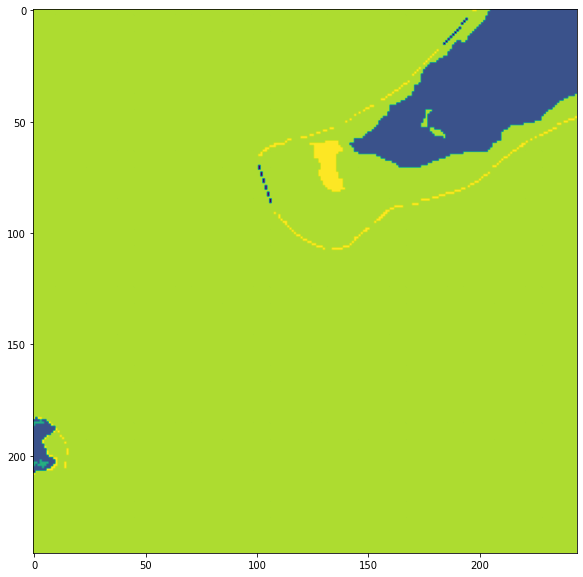

In [6]:
plt.imshow(T[idx,:,:])
f = plt.gcf()
f.set_size_inches(10, 10)
plt.savefig('t1.png')
plt.show()

In [7]:
# Class 0 signifies nodata
classes = np.unique(T.flatten())
print(classes)

[0 1 2 3 4 5 6 7 8]


# Testing data

In [8]:
# Band 1: blue; Band 2: green; Band 3: red; Band 4: nir
I1 = np.load(os.path.join('../data/Validation.npy'))
I1.shape

(4, 3059, 366, 366)

## Test sample data

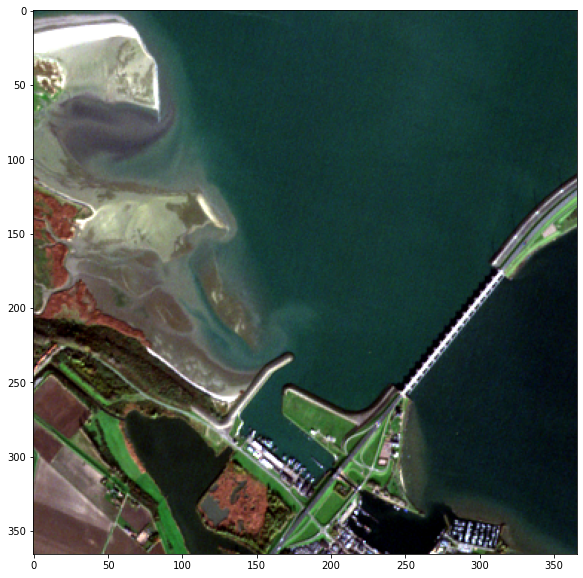

In [9]:
idx = 51
tmp = np.zeros((I1.shape[2], I1.shape[3], 3), dtype=np.uint8)
for q in range(3):
    a = copy.copy(I1[q,idx,:,:])
    D = a>0
    prc = np.percentile(a[D],[1,99])
    tmp[:,:,2-q] = np.digitize(a,np.linspace(prc[0],prc[1],255))*D
plt.imshow(tmp)
plt.savefig('t.png')
f = plt.gcf()
f.set_size_inches(10, 10)
plt.show()

In [10]:
T1 = np.load('../data/Validation_Targets.npy')
T1.shape

(3059, 366, 366)

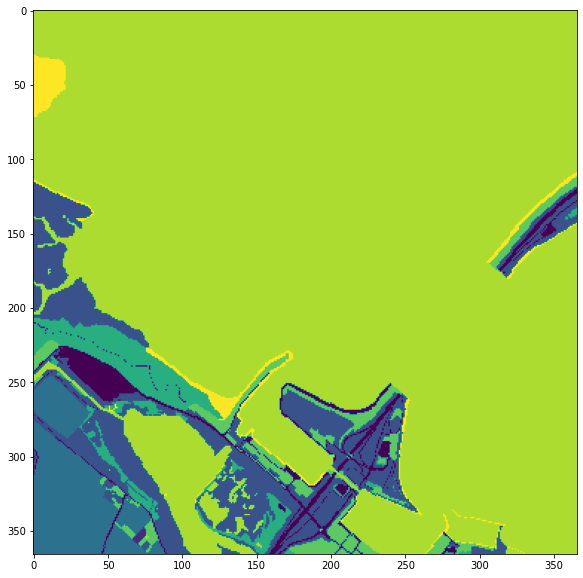

In [11]:
plt.imshow(T1[idx,:,:])
f = plt.gcf()
f.set_size_inches(10, 10)
plt.show()

# Standardize data

The part of standardize data is not necessary when PNG images are created. 

In [12]:
X = np.float32(I)
X[X>10000] = 10000
X = X / 10000.
X.shape

(4, 3344, 244, 244)

In [13]:
X1 = np.float32(I1)
X1[X1>10000] = 10000
X1 = X1 / 10000.
X1.shape

(4, 3059, 366, 366)

In [14]:
X = np.rollaxis(X, 0, 4)
xshape = X.shape
print(xshape)

(3344, 244, 244, 4)


In [15]:
X1 = np.rollaxis(X1, 0, 4)
x1shape = X1.shape
print(x1shape)

(3059, 366, 366, 4)


In [16]:
mu = np.zeros((4,))
std = np.zeros((4,))
for q in range(X1.shape[3]):
    tmp = copy.copy(X1[:, :, :, q])
    tmp = tmp.flatten()
    mu[q] = tmp[tmp>0].mean()
    std[q] = tmp[tmp>0].std()
    print(mu[q], std[q])
    tmp[tmp>0] = (tmp[tmp>0] - mu[q]) / std[q]
    X1[:, :, :, q] = tmp.reshape(X1.shape[0], X1.shape[1], X1.shape[2])
    del tmp

0.03284856304526329 0.023617200553417206
0.05240388959646225 0.02747962810099125
0.0436774380505085 0.03299689665436745
0.19594991207122803 0.15419800579547882


In [17]:
mu = np.zeros((4,))
std = np.zeros((4,))
for q in range(X1.shape[3]):
    tmp = copy.copy(X[:, :, :, q])
    tmp = tmp.flatten()
    mu[q] = tmp[tmp>0].mean()
    std[q] = tmp[tmp>0].std()
    print(mu[q], std[q])
    tmp[tmp>0] = (tmp[tmp>0] - mu[q]) / std[q]
    X[:, :, :, q] = tmp.reshape(X.shape[0], X.shape[1], X.shape[2])
    del tmp

0.12655076384544373 0.016980711370706558
0.09710454940795898 0.016959035769104958
0.07182221114635468 0.023930516093969345
0.17956602573394775 0.12075547128915787


In [18]:
Y = np.zeros(T.shape +  (len(classes),), dtype=np.float32)
for q in range(len(classes)):
    tmp = Y[:,:,:,q]
    tmp[T==q] = 1
    Y[:,:,:,q] = tmp
print(Y.shape)

(3344, 244, 244, 9)


In [19]:
Y1 = np.zeros(T1.shape +  (len(classes),), dtype=np.float32)
for q in range(len(classes)):
    tmp = Y1[:,:,:,q]
    tmp[T1==q] = 1
    Y1[:,:,:,q] = tmp
print(Y1.shape)

(3059, 366, 366, 9)


In [20]:
X= X[:,:224,:224,:]
Y= Y[:,:224,:224,:]


In [21]:
X1= X1[:,:224,:224,:]
Y1= Y1[:,:224,:224,:]


In [22]:
T1.shape

(3059, 366, 366)

In [23]:
I.shape

(4, 3344, 244, 244)

# Save data as PNG

## Make the input files the same dimension to fit DL network

In [24]:
I= I[:,:,:224,:224]
T= T[:,:224,:224]
I1= I1[:,:,:224,:224]
T1= T1[:,:224,:224]

## Check if all dimensions are right

In [25]:
print(I.shape)
print(T.shape)
print(I1.shape)
print(T1.shape)


(4, 3344, 224, 224)
(3344, 224, 224)
(4, 3059, 224, 224)
(3059, 224, 224)


In [26]:
T.shape[0]

3344

## Convert from Numpy array to PNG

the np.std( ) functions test if the annoated image is completely bellongs to one class. If this is the case then there is an error in reaading the files. Those files are stored separately in folders with name _wrong 

also those images that have only 1 or 2 classes are not included as most of them are wrong images.
It is important to notice that large water bodies e.g. sea, oceans, and lakes will be not well recognized by using this method. Solution would be to map these large water bodies before and after, or make a special method just for their recognition. There is no real advantaage of recognizing fixed water bodies that can be extraced from any map directly. 
In Kaggle competitions often the large water bodies were recognized by separate model. 

The data at the end must be analyzed visualy for inspection. If there are obvious wrong images they must be removed from training and testing data.

## all data is stored as train

In [27]:
from PIL import Image
for i in range(T.shape[0]):
#for i in range(50):
    
    if np.std(T[i,:,:])>0 and np.unique(T[i,:,:]).size>2:
        tmp = np.zeros((I.shape[2], I.shape[3], 3), dtype=np.uint8)
        for q in range(3):
            a = copy.copy(I[q,i,:,:])
            D = a>0
            prc = np.percentile(a[D],[1,99])
            tmp[:,:,2-q] = np.digitize(a,np.linspace(prc[0],prc[1],255))*D
        image = Image.fromarray(tmp)
        image.save('../dataset/images_prepared_train/'+str(i) + '.png')
        AnnotatedImage = Image.fromarray(T[i,:,:])
        AnnotatedImage.save('../dataset/annotation_prepared_train/'+str(i) + '.png')
    else:
        tmp = np.zeros((I.shape[2], I.shape[3], 3), dtype=np.uint8)
        for q in range(3):
            a = copy.copy(I[q,i,:,:])
            D = a>0
            prc = np.percentile(a[D],[1,99])
            tmp[:,:,2-q] = np.digitize(a,np.linspace(prc[0],prc[1],255))*D
        image = Image.fromarray(tmp)
        image.save('../dataset/images_prepared_train_wrong/'+str(i) + '.png')
        AnnotatedImage = Image.fromarray(T[i,:,:])
        AnnotatedImage.save('../dataset/annotation_prepared_train_wrong/'+str(i) + '.png')


In [28]:
from PIL import Image
for i in range(T1.shape[0]):
#for i in range(500):
    
    if np.std(T1[i,:,:])>0 and np.unique(T1[i,:,:]).size>2:
        tmp = np.zeros((I1.shape[2], I1.shape[3], 3), dtype=np.uint8)
        for q in range(3):
            a = copy.copy(I1[q,i,:,:])
            D = a>0
            prc = np.percentile(a[D],[1,99])
            tmp[:,:,2-q] = np.digitize(a,np.linspace(prc[0],prc[1],255))*D
        im = Image.fromarray(tmp)
        im.save('../dataset/images_prepared_train/a'+str(i) + '.png')
        AnnotatedImage = Image.fromarray(T1[i,:,:])
        AnnotatedImage.save('../dataset/annotation_prepared_train/a'+str(i) + '.png')
    else:
        tmp = np.zeros((I1.shape[2], I1.shape[3], 3), dtype=np.uint8)
        for q in range(3):
            a = copy.copy(I1[q,i,:,:])
            D = a>0
            prc = np.percentile(a[D],[1,99])
            tmp[:,:,2-q] = np.digitize(a,np.linspace(prc[0],prc[1],255))*D
        image = Image.fromarray(tmp)
        image.save('../dataset/images_prepared_train_wrong/a'+str(i) + '.png')
        AnnotatedImage = Image.fromarray(T1[i,:,:])
        AnnotatedImage.save('../dataset/annotation_prepared_train_wrong/a'+str(i) + '.png')

